In [102]:
# basic imports for a Fourier Neural Operator
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam, AdamW
import matplotlib.pyplot as plt
from neuralop.datasets import load_spherical_swe

from torch_harmonics import *

device = 'mps'

In [103]:
# Loading the Navier-Stokes dataset in 128x128 resolution

train_resolution = (32, 64)
test_resolution_2 = (train_resolution[0] * 2, train_resolution[1] * 2)

train_loader, test_loaders = load_spherical_swe(
    n_train=200,
    batch_size=4,
    train_resolution=train_resolution,
    test_resolutions=[train_resolution, test_resolution_2],
    n_tests=[50, 50],
    test_batch_sizes=[10, 10],
)

## divide the dataloaders for the two resolutions
test_loader_1 = test_loaders[train_resolution]
test_loader_2 = test_loaders[test_resolution_2]

Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=4
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


---
### Exploring the dataloader stucture

In [104]:
dizionario = next(iter(train_loader))
dizionario['x']

tensor([[[[-1.7798, -1.7798, -1.7798,  ..., -1.7798, -1.7798, -1.7798],
          [-1.5403, -1.6347, -1.7312,  ..., -1.2685, -1.3573, -1.4478],
          [-0.8882, -0.9669, -1.0663,  ..., -0.7125, -0.7683, -0.8244],
          ...,
          [-0.0444, -0.1749, -0.3120,  ...,  0.3002,  0.1933,  0.0785],
          [-0.5362, -0.6050, -0.6770,  ..., -0.3607, -0.4130, -0.4719],
          [-1.1917, -1.1917, -1.1917,  ..., -1.1917, -1.1917, -1.1917]],

         [[-0.3972, -0.3972, -0.3972,  ..., -0.3972, -0.3972, -0.3972],
          [ 0.0200,  0.0790,  0.1352,  ..., -0.1662, -0.1033, -0.0410],
          [ 0.3153,  0.3985,  0.4789,  ...,  0.0567,  0.1437,  0.2301],
          ...,
          [ 0.3541,  0.4190,  0.4712,  ...,  0.1447,  0.2110,  0.2827],
          [-0.2346, -0.2490, -0.2695,  ..., -0.2160, -0.2193, -0.2251],
          [-0.7250, -0.7250, -0.7250,  ..., -0.7250, -0.7250, -0.7250]],

         [[ 1.0175,  1.0175,  1.0175,  ...,  1.0175,  1.0175,  1.0175],
          [ 1.5199,  1.4962,  

In [105]:
dizionario['x'].shape

torch.Size([4, 3, 32, 64])

Here we can see that we have that both the input and the target images are in the format `(batch_size,channels,n_lat,n_long)`

In [106]:
torch.min(dizionario['y'][0, :, :, :]), torch.max(dizionario['y'][0, :, :, :])

(tensor(-5.2060), tensor(7.8141))

The format of the channels is weird because is not in a standard format for images 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 64])


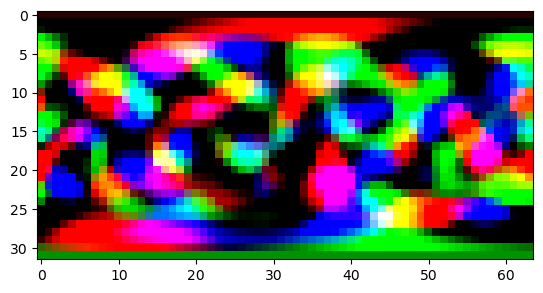

In [107]:
# plot the input as 2d
first_datum = dizionario['x'][3,:,:,:]
print(first_datum.shape)
plt.imshow(first_datum.permute(1, 2, 0))

# try to plot the input in 3d
cmap = 'turbo'

In [108]:
## Accessory function to add the spatial information to the channels

def add_spatial_information(x):
    """
    Function to add the spatial information to the channels 

    input: x: torch.tensor of shape (batch_size, n_channels, n_theta, n_lambda)
    output: x: torch.tensor of shape (batch_size, n_channels + 2, n_theta, n_lambda) where 
                channel 4 is theta (latutude) and channel 5 is phi (longitude)
    """

    n_theta = x.shape[2]
    n_lambda = x.shape[3]
    theta = torch.linspace(0, np.pi, n_theta).view(1, 1, n_theta, 1)
    phi = torch.linspace(0, 2*np.pi, n_lambda).view(1, 1, 1, n_lambda)
    theta = theta.repeat(x.shape[0], 1, 1, n_lambda)
    phi = phi.repeat(x.shape[0], 1, n_theta, 1)
    x = torch.cat([x, theta, phi], dim=1)
    return x

In [109]:
## test the function
x = torch.randn(4, 3, 32, 64)
x_with_spatial = add_spatial_information(x)

print("Testing shapes")
print("x shape: ", x.shape)
print("x_with_spatial shape: ", x_with_spatial.shape, "\n")

print("Testing values")
print("Look at latitude values", x_with_spatial[0, 3, :, :])
print("Look at longitude values", x_with_spatial[0, 4, :, :])

Testing shapes
x shape:  torch.Size([4, 3, 32, 64])
x_with_spatial shape:  torch.Size([4, 5, 32, 64]) 

Testing values
Look at latitude values tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1013, 0.1013, 0.1013,  ..., 0.1013, 0.1013, 0.1013],
        [0.2027, 0.2027, 0.2027,  ..., 0.2027, 0.2027, 0.2027],
        ...,
        [2.9389, 2.9389, 2.9389,  ..., 2.9389, 2.9389, 2.9389],
        [3.0403, 3.0403, 3.0403,  ..., 3.0403, 3.0403, 3.0403],
        [3.1416, 3.1416, 3.1416,  ..., 3.1416, 3.1416, 3.1416]])
Look at longitude values tensor([[0.0000, 0.0997, 0.1995,  ..., 6.0837, 6.1835, 6.2832],
        [0.0000, 0.0997, 0.1995,  ..., 6.0837, 6.1835, 6.2832],
        [0.0000, 0.0997, 0.1995,  ..., 6.0837, 6.1835, 6.2832],
        ...,
        [0.0000, 0.0997, 0.1995,  ..., 6.0837, 6.1835, 6.2832],
        [0.0000, 0.0997, 0.1995,  ..., 6.0837, 6.1835, 6.2832],
        [0.0000, 0.0997, 0.1995,  ..., 6.0837, 6.1835, 6.2832]])


--------
### Implementation of the Neural Operator 

In [110]:
################################################################
#  2d spherical fourier layer
################################################################
class SpectralConv2d_Spectral(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_Spectral, self).__init__()

        """
        2D Fourier layer. It does SHT, linear transform, and Inverse SHT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = (
            modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        )
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(
                in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat
            )
        )
        self.weights2 = nn.Parameter(
            self.scale
            * torch.rand(
                in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat
            )
        )

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        
        ## Remember the data is in the format (batchsize, c=3, y=n_lat, x=n_long)
        ##theta should be the mesure associated with latitude
        ##lambda should be the measure associated with longitude
        n_theta = x.shape[2]
        n_lambda = x.shape[3]
        sht = RealSHT(n_theta, n_lambda, grid="equiangular")
        isht = InverseRealSHT(n_theta, n_lambda, grid="equiangular")

        x_ft = sht(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-2),
            x.size(-1) // 2 + 1,
            dtype=torch.cfloat,
            device=x.device,
        )
        out_ft[:, :, : self.modes1, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, : self.modes1, : self.modes2], self.weights1
        )
        out_ft[:, :, -self.modes1 :, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, -self.modes1 :, : self.modes2], self.weights2
        )

        # Return to physical space
        # x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        x = isht(out_ft)
        return x


class SFNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, n_layers = 3, device=None, padding_frac=1 / 4):
        super(SFNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=1)
        """
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_layers = n_layers

        ##I don't know how would you use this 
        # self.retrain_fno = fno_architecture["retrain_fno"]
        # torch.manual_seed(self.retrain_fno)

        # self.padding = 9 # pad the domain if input is non-periodic
        self.padding_frac = padding_frac
        self.fc0 = nn.Linear(5, self.width)  # input channel is 5: (a(x, y), b(x,y), c(x,y) lat, long)

        self.conv_list = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)]
        )
        self.spectral_list = nn.ModuleList(
            [
                SpectralConv2d_Spectral(self.width, self.width, self.modes1, self.modes2)
                for _ in range(self.n_layers)
            ]
        )

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 3)

        self.to(device)

    def forward(self, x):
        ## we need to go from (batchsize, c=3, y=n_lat, x=n_long) [how our data are originally given] to (batchsize, ?y=s, ?x=s, c=3) (maybe inverted x and y)
        ## that is what the network was designed for 

        # print("Shape pre permutation", x.shape)
        x = x.permute(0, 2, 3, 1)
        # print("Shape post permutation pre lifting", x.shape)
        x = self.fc0(x)
        # print("Shape after lifting", x.shape)
        x = x.permute(0, 3, 1, 2)
        # print("Shape after lifting after repermutation", x.shape)

        # x1_padding = int(round(x.shape[-1] * self.padding_frac))
        # x2_padding = int(round(x.shape[-2] * self.padding_frac))
        # x = F.pad(x, [0, x1_padding, 0, x2_padding])
        
        # print("Shape after padding", x.shape)

        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            # print("Shape after spectral layer", x1.shape)
            x2 = c(x)
            # print("Shape after conv layer", x2.shape)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = F.gelu(x)
        # x = x[..., :-x1_padding, :-x2_padding]

        x = x.permute(0, 2, 3, 1)
        # print("Shape before projection", x.shape)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        # print("Shape after projection", x.shape)
        ## we do the inverse tranformation of what we have done at the beginning, so we go from (batchsize, x=s, y=s, c=3) 
        ## to (batchsize, c=3, y=n_lat, x=n_long)
        x = x.permute(0, 3, 1, 2)
        # print("Shape before returning", x.shape)
        # print("\n")
        return x

In [111]:
## Instantiate the model parameters

learning_rate = 0.001
epochs = 30 # = 250
step_size = 50
gamma = 0.5

modes1 = 16
modes2 = 16
width = 100
n_layers = 4
sfno2d = SFNO2d(modes1, modes2, width=width, n_layers= n_layers) # model

In [112]:
## Train the model
optimizer = Adam(sfno2d.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

print("########### TRAINING SFNO2D ###########")
print("# for train resolution", train_resolution, "#")
print("# for test resolution 1", train_resolution, "#")
print("# for test resolution 2", test_resolution_2, "#")

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, dizionario in enumerate(train_loader):
        optimizer.zero_grad()
        input_with_spatial = add_spatial_information(dizionario["x"])
        output_pred_batch = sfno2d(input_with_spatial).squeeze(2)
        loss_f = l(output_pred_batch, dizionario['y'])
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(train_loader)

    scheduler.step()

    with torch.no_grad():
        sfno2d.eval()
        test_relative_l2_1 = 0.0
        for step, dizionario in enumerate(test_loader_1):
            input_with_spatial = add_spatial_information(dizionario["x"])
            output_pred_batch = sfno2d(input_with_spatial).squeeze(2)
            output_batch = dizionario['y']
            loss_f = (
                torch.mean((output_pred_batch - output_batch) ** 2)
                / torch.mean(output_batch**2)
            ) ** 0.5 * 100
            test_relative_l2_1 += loss_f.item()
        test_relative_l2_1 /= len(test_loader_1)

    with torch.no_grad():
        sfno2d.eval()
        test_relative_l2_2 = 0.0
        for step, dizionario in enumerate(test_loader_2):
            input_with_spatial = add_spatial_information(dizionario["x"])
            output_pred_batch = sfno2d(input_with_spatial).squeeze(2)
            output_batch = dizionario['y']
            loss_f = (
                torch.mean((output_pred_batch - output_batch) ** 2)
                / torch.mean(output_batch**2)
            ) ** 0.5 * 100
            test_relative_l2_2 += loss_f.item()
        test_relative_l2_2 /= len(test_loader_2)

    

    if epoch % freq_print == 0:
        print(
            "##### Epoch:",
            epoch,
            " ##### Train Loss",
            train_mse,
            " ##### Relative L2 Test Norm for training resolution:",
            test_relative_l2_1,
            " ##### Relative L2 Test Norm: for double resolution",
            test_relative_l2_2,
        )

########### TRAINING SFNO2D ###########
# for train resolution (32, 64) #
# for test resolution 1 (32, 64) #
# for test resolution 2 (64, 128) #
##### Epoch: 0  ##### Train Loss 0.5167352528870106  ##### Relative L2 Test Norm for training resolution: 20.528149795532226  ##### Relative L2 Test Norm: for double resolution 73.71925659179688
##### Epoch: 1  ##### Train Loss 0.03562345512211323  ##### Relative L2 Test Norm for training resolution: 15.74860076904297  ##### Relative L2 Test Norm: for double resolution 73.36246643066406
##### Epoch: 2  ##### Train Loss 0.018328394964337347  ##### Relative L2 Test Norm for training resolution: 14.157293891906738  ##### Relative L2 Test Norm: for double resolution 72.52081451416015
##### Epoch: 3  ##### Train Loss 0.015167829375714063  ##### Relative L2 Test Norm for training resolution: 13.575456619262695  ##### Relative L2 Test Norm: for double resolution 73.36353759765625
##### Epoch: 4  ##### Train Loss 0.013041354473680258  ##### Relative L

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


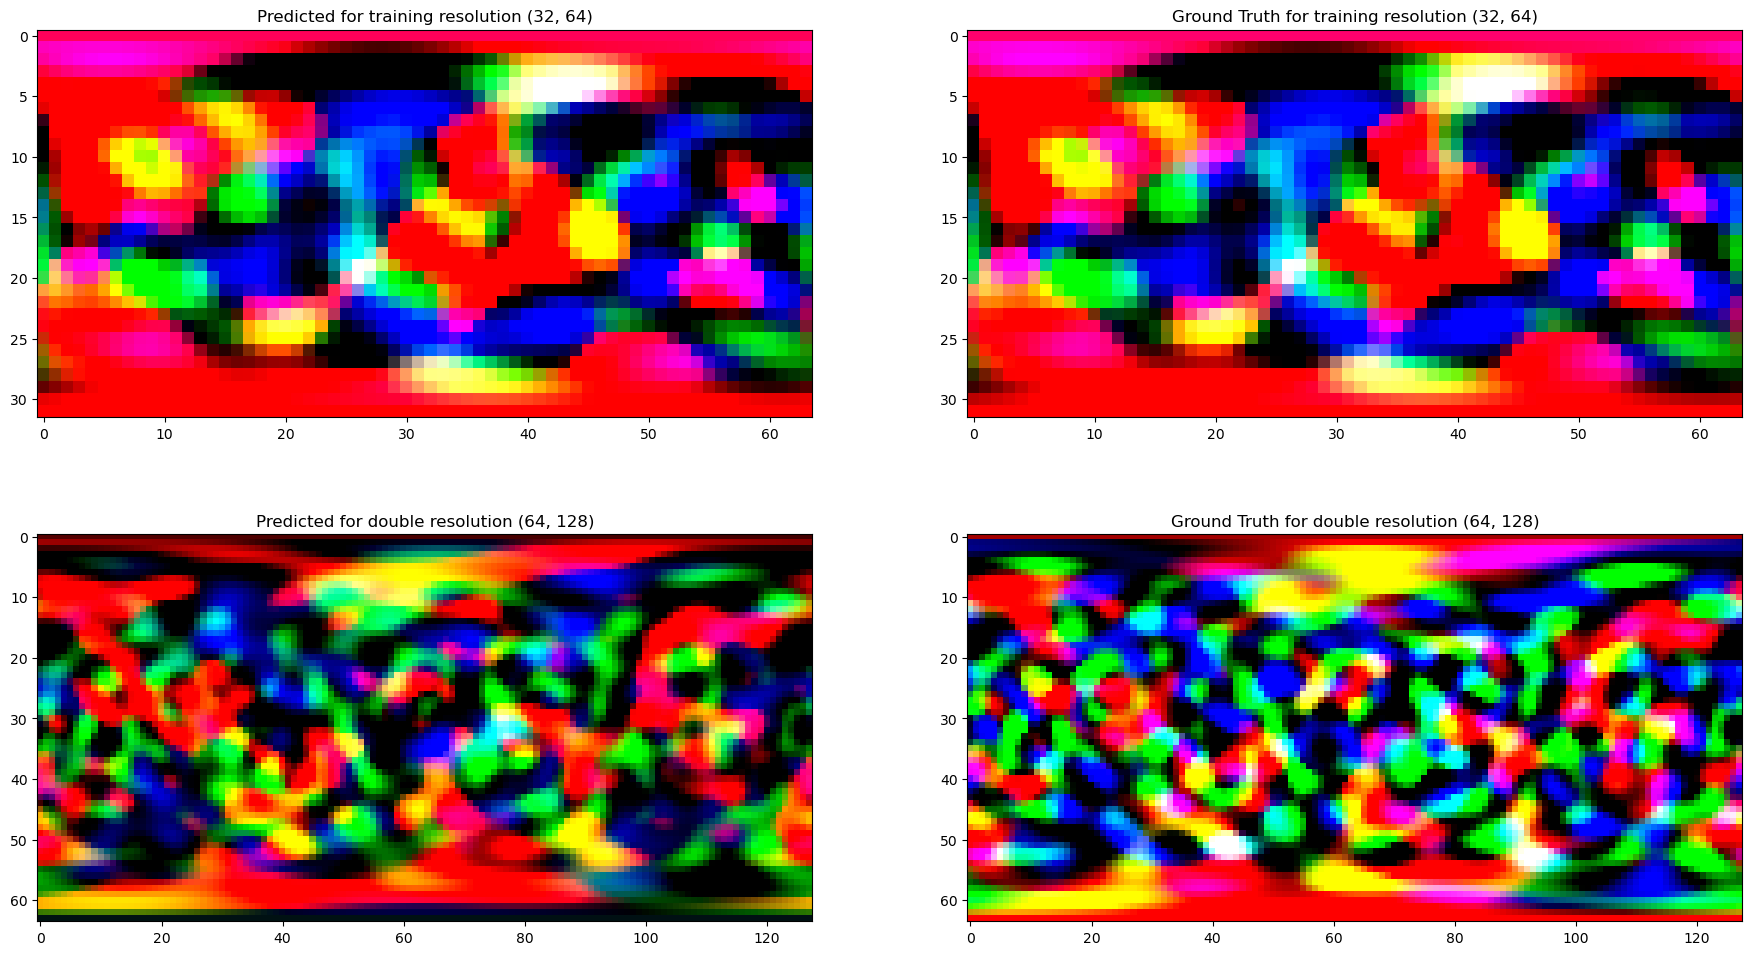

In [113]:
## plot the results compared to the ground truth

# create two subplots for the predicted and the ground truth
fig, axs = plt.subplots(2, 2, figsize=(22, 12))

with torch.no_grad():
    sfno2d.eval()
    for step, dizionario in enumerate(test_loader_1):
        input_with_spatial_1 = add_spatial_information(dizionario["x"])
        output_pred_batch_1 = sfno2d(input_with_spatial_1).squeeze(2)
        output_batch_1 = dizionario['y']
        break
    for step, dizionario in enumerate(test_loader_2):
        input_with_spatial_2 = add_spatial_information(dizionario["x"])
        output_pred_batch_2 = sfno2d(input_with_spatial_2).squeeze(2)
        output_batch_2 = dizionario['y']
        break

# plot the predicted
batch_number = 2

first_datum = output_pred_batch_1[batch_number, :, :].cpu()
axs[0,0].imshow(first_datum.permute(1, 2, 0), cmap='RdBu')
axs[0,0].set_title(f"Predicted for training resolution {train_resolution}")

# plot the ground truth
first_datum = output_batch_1[batch_number, :, :].cpu()
axs[0,1].imshow(first_datum.permute(1, 2, 0), cmap='RdBu')
axs[0,1].set_title(f"Ground Truth for training resolution {train_resolution}")

#for the other resolution 
first_datum = output_pred_batch_2[batch_number, :, :].cpu()
axs[1,0].imshow(first_datum.permute(1, 2, 0), cmap='RdBu')
axs[1,0].set_title(f"Predicted for double resolution {test_resolution_2}")

# plot the ground truth
first_datum = output_batch_2[batch_number, :, :].cpu()
axs[1,1].imshow(first_datum.permute(1, 2, 0), cmap='RdBu')
axs[1,1].set_title(f"Ground Truth for double resolution {test_resolution_2}")

plt.show()

-----

## Baseline: Normal 2dFNO

In [114]:
################################################################
#  2d fourier layer
################################################################
class Normal_SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(Normal_SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = (
            modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        )
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(
            self.scale
            * torch.rand(
                in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat
            )
        )
        self.weights2 = nn.Parameter(
            self.scale
            * torch.rand(
                in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat
            )
        )

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)

        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-2),
            x.size(-1) // 2 + 1,
            dtype=torch.cfloat,
            device=x.device,
        )
        out_ft[:, :, : self.modes1, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, : self.modes1, : self.modes2], self.weights1
        )
        out_ft[:, :, -self.modes1 :, : self.modes2] = self.compl_mul2d(
            x_ft[:, :, -self.modes1 :, : self.modes2], self.weights2
        )

        # Return to physical space
        # x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))

        return x


class FNO2d(nn.Module):
    def __init__(
        self, modes1, modes2, width, n_layers=3, device=None, padding_frac=1 / 4
    ):
        super(FNO2d, self).__init__()

        """
        Same as SFNO2d but with normal Fourier layer.
        """
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.n_layers = n_layers

        ##I don't know how would you use this
        # self.retrain_fno = fno_architecture["retrain_fno"]
        # torch.manual_seed(self.retrain_fno)

        # self.padding = 9 # pad the domain if input is non-periodic
        self.padding_frac = padding_frac
        self.fc0 = nn.Linear(
            5, self.width
        )  # input channel is 5: (a(x, y), b(x,y), c(x,y) lat, long)

        self.conv_list = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)]
        )
        self.spectral_list = nn.ModuleList(
            [
                Normal_SpectralConv2d(
                    self.width, self.width, self.modes1, self.modes2
                )
                for _ in range(self.n_layers)
            ]
        )

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 3)

        self.to(device)

    def forward(self, x):
        ## we need to go from (batchsize, c=3, y=n_lat, x=n_long) [how our data are originally given] to (batchsize, ?y=s, ?x=s, c=3) (maybe inverted x and y)
        ## that is what the network was designed for

        # print("Shape pre permutation", x.shape)
        x = x.permute(0, 2, 3, 1)
        # print("Shape post permutation pre lifting", x.shape)
        x = self.fc0(x)
        # print("Shape after lifting", x.shape)
        x = x.permute(0, 3, 1, 2)
        # print("Shape after lifting after repermutation", x.shape)

        # x1_padding = int(round(x.shape[-1] * self.padding_frac))
        # x2_padding = int(round(x.shape[-2] * self.padding_frac))
        # x = F.pad(x, [0, x1_padding, 0, x2_padding])

        # print("Shape after padding", x.shape)

        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            # print("Shape after spectral layer", x1.shape)
            x2 = c(x)
            # print("Shape after conv layer", x2.shape)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = F.gelu(x)
        # x = x[..., :-x1_padding, :-x2_padding]

        x = x.permute(0, 2, 3, 1)
        # print("Shape before projection", x.shape)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        # print("Shape after projection", x.shape)
        ## we do the inverse tranformation of what we have done at the beginning, so we go from (batchsize, x=s, y=s, c=3)
        ## to (batchsize, c=3, y=n_lat, x=n_long)
        x = x.permute(0, 3, 1, 2)
        # print("Shape before returning", x.shape)
        # print("\n")
        return x

In [115]:
## Instantiate the model parameters

learning_rate = 0.001
epochs = 30  # = 250
step_size = 50
gamma = 0.5

modes1 = 16
modes2 = 16
width = 100
n_layers = 4
fno2d = FNO2d(modes1, modes2, width=width, n_layers=n_layers)  # model

In [116]:
## Train the model
optimizer = Adam(fno2d.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

print("########### TRAINING FNO2D ###########")
print("# for train resolution", train_resolution, "#")
print("# for test resolution 1", train_resolution, "#")
print("# for test resolution 2", test_resolution_2, "#")

l = torch.nn.MSELoss()
freq_print = 1
for epoch in range(epochs):
    train_mse = 0.0
    for step, dizionario in enumerate(train_loader):
        optimizer.zero_grad()
        input_with_spatial = add_spatial_information(dizionario["x"])
        output_pred_batch = fno2d(input_with_spatial).squeeze(2)
        loss_f = l(output_pred_batch, dizionario["y"])
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(train_loader)

    scheduler.step()

    with torch.no_grad():
        fno2d.eval()
        test_relative_l2_1 = 0.0
        for step, dizionario in enumerate(test_loader_1):
            input_with_spatial = add_spatial_information(dizionario["x"])
            output_pred_batch = fno2d(input_with_spatial).squeeze(2)
            output_batch = dizionario["y"]
            loss_f = (
                torch.mean((output_pred_batch - output_batch) ** 2)
                / torch.mean(output_batch**2)
            ) ** 0.5 * 100
            test_relative_l2_1 += loss_f.item()
        test_relative_l2_1 /= len(test_loader_1)

    with torch.no_grad():
        fno2d.eval()
        test_relative_l2_2 = 0.0
        for step, dizionario in enumerate(test_loader_2):
            input_with_spatial = add_spatial_information(dizionario["x"])
            output_pred_batch = fno2d(input_with_spatial).squeeze(2)
            output_batch = dizionario["y"]
            loss_f = (
                torch.mean((output_pred_batch - output_batch) ** 2)
                / torch.mean(output_batch**2)
            ) ** 0.5 * 100
            test_relative_l2_2 += loss_f.item()
        test_relative_l2_2 /= len(test_loader_2)

    if epoch % freq_print == 0:
        print(
            "##### Epoch:",
            epoch,
            " ##### Train Loss",
            train_mse,
            " ##### Relative L2 Test Norm for training resolution:",
            test_relative_l2_1,
            " ##### Relative L2 Test Norm: for double resolution",
            test_relative_l2_2,
        )

########### TRAINING FNO2D ###########
# for train resolution (32, 64) #
# for test resolution 1 (32, 64) #
# for test resolution 2 (64, 128) #
##### Epoch: 0  ##### Train Loss 0.6573921087384224  ##### Relative L2 Test Norm for training resolution: 33.4041015625  ##### Relative L2 Test Norm: for double resolution 76.55063323974609
##### Epoch: 1  ##### Train Loss 0.13209092050790786  ##### Relative L2 Test Norm for training resolution: 24.234585189819335  ##### Relative L2 Test Norm: for double resolution 82.5048599243164
##### Epoch: 2  ##### Train Loss 0.06641272805631161  ##### Relative L2 Test Norm for training resolution: 21.01711082458496  ##### Relative L2 Test Norm: for double resolution 78.10093231201172
##### Epoch: 3  ##### Train Loss 0.03713375668972731  ##### Relative L2 Test Norm for training resolution: 17.214646530151366  ##### Relative L2 Test Norm: for double resolution 76.12105865478516
##### Epoch: 4  ##### Train Loss 0.022792156040668487  ##### Relative L2 Test No

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


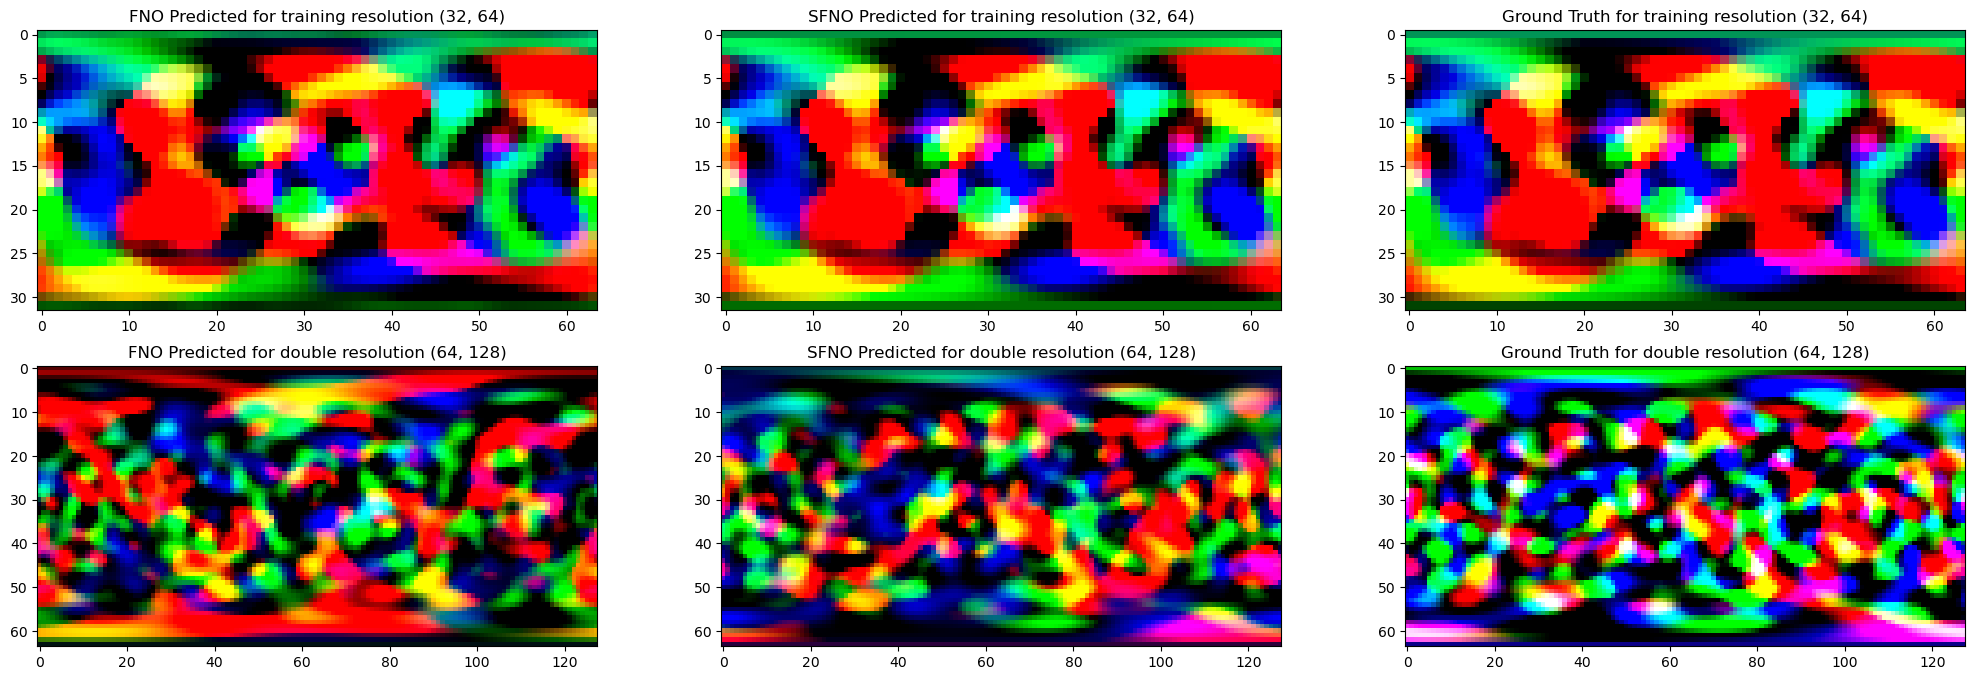

In [117]:
## plot the results compared to the ground truth

# create two subplots for the predicted and the ground truth
fig, axs = plt.subplots(2, 3, figsize=(25, 8))

with torch.no_grad():
    fno2d.eval()
    sfno2d.eval()
    for step, dizionario in enumerate(test_loader_1):
        input_with_spatial_1 = add_spatial_information(dizionario["x"])
        output_pred_batch_1_fno = fno2d(input_with_spatial_1).squeeze(2)
        output_pred_batch_1_sfno = sfno2d(input_with_spatial_1).squeeze(2)
        output_batch_1 = dizionario["y"]
        break
    for step, dizionario in enumerate(test_loader_2):
        input_with_spatial_2 = add_spatial_information(dizionario["x"])
        output_pred_batch_2_fno = fno2d(input_with_spatial_2).squeeze(2)
        output_pred_batch_2_sfno = sfno2d(input_with_spatial_2).squeeze(2)
        output_batch_2 = dizionario["y"]
        break

# plot the predicted
batch_number = 2

first_datum = output_pred_batch_1_fno[batch_number, :, :].cpu()
axs[0, 0].imshow(first_datum.permute(1, 2, 0), cmap="RdBu")
axs[0, 0].set_title(f"FNO Predicted for training resolution {train_resolution}")

first_datum = output_pred_batch_1_sfno[batch_number, :, :].cpu()
axs[0, 1].imshow(first_datum.permute(1, 2, 0), cmap="RdBu")
axs[0, 1].set_title(f"SFNO Predicted for training resolution {train_resolution}")

# plot the ground truth
first_datum = output_batch_1[batch_number, :, :].cpu()
axs[0, 2].imshow(first_datum.permute(1, 2, 0), cmap="RdBu")
axs[0, 2].set_title(f"Ground Truth for training resolution {train_resolution}")

# for the other resolution
first_datum = output_pred_batch_2[batch_number, :, :].cpu()
axs[1, 0].imshow(first_datum.permute(1, 2, 0), cmap="RdBu")
axs[1, 0].set_title(f"FNO Predicted for double resolution {test_resolution_2}")

first_datum = output_pred_batch_2_sfno[batch_number, :, :].cpu()
axs[1, 1].imshow(first_datum.permute(1, 2, 0), cmap="RdBu")
axs[1, 1].set_title(f"SFNO Predicted for double resolution {test_resolution_2}")

# plot the ground truth
first_datum = output_batch_2[batch_number, :, :].cpu()
axs[1, 2].imshow(first_datum.permute(1, 2, 0), cmap="RdBu")
axs[1, 2].set_title(f"Ground Truth for double resolution {test_resolution_2}")

plt.show()